[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [13]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [14]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [15]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [16]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
poem_prompt = """Write a short poem about {subject}"""
best_poem_prompt = """Below are a bunch of poems about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first poem. Poems: \n\n  {poems}"""

# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [17]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestPoem(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    poems: Annotated[list, operator.add]
    best_selected_poem: str

Generate subjects for jokes.

In [18]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [19]:
from langgraph.types import Send
def continue_to_poems(state: OverallState):
    return [Send("generate_poem", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [20]:
class PoemState(TypedDict):
    subject: str

class Poem(BaseModel):
    poem: str

def generate_poem(state: PoemState):
    prompt = poem_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Poem).invoke(prompt)
    return {"poems": [response.poem]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [21]:
def best_poem(state: OverallState):
    poems = "\n\n".join(state["poems"])
    prompt = best_poem_prompt.format(topic=state["topic"], poems=poems)
    response = model.with_structured_output(BestPoem).invoke(prompt)
    return {"best_selected_poem": state["poems"][response.id]}

## Compile

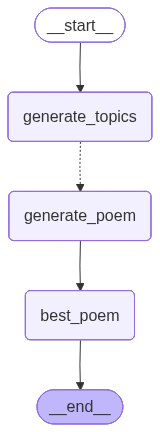

In [22]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_poem", generate_poem)
graph.add_node("best_poem", best_poem)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_poems, ["generate_poem"])
graph.add_edge("generate_poem", "best_poem")
graph.add_edge("best_poem", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [24]:
# Call the graph: here we call it to generate a list of poems
for s in app.stream({"topic": "Pens"}):
    print(s)

{'generate_topics': {'subjects': ['History of Writing Instruments', 'Innovations in Pen Technology', 'Environmental Impact of Disposable Pens']}}
{'generate_poem': {'poems': ["In the realm of ink and quill, where stories once began,  \nA new dawn rises, led by the inventive hand.  \nFrom feathered tips to ballpoint grace,  \nThe pen evolves, a timeless race.\n\nOnce dipped in wells of midnight blue,  \nNow cartridges of every hue,  \nWith clicks and twists, the ink flows free,  \nA symphony of creativity.\n\nErgonomic curves that fit just right,  \nIn hands that dream and hearts that write,  \nWith pressure sensors, they now detect,  \nThe weight of thoughts, the mind's dialect.\n\nSmart pens that sync with digital skies,  \nTranscribing words with no disguise,  \nFrom paper to screen, a seamless flight,  \nBridging worlds of day and night.\n\nIn the dance of innovation's light,  \nThe pen remains a beacon bright,  \nA tool of change, a scribe's delight,  \nIn every stroke, a future's 

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.